In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.spatial.transform import Rotation

np.random.seed(42)


In [12]:
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
      images = images.squeeze(axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
      plt.subplot(n_rows, n_cols, index + 1)
      plt.imshow(image, cmap="binary")
      plt.axis("off")

In [2]:
# Loading fashion MNIST

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [10]:
# Building a GAN

codings_size = 30
Dense = tf.keras.layers.Dense

# Generator
generator = tf.keras.models.Sequential([
  Dense(100, activation="relu", kernel_initializer="he_normal"),
  Dense(150, activation="relu", kernel_initializer="he_normal"),
  Dense(28 * 28, activation="sigmoid"),
  tf.keras.layers.Reshape([28, 28])
])

# Discriminator
discriminator = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  Dense(150, activation="relu", kernel_initializer="he_normal"),
  Dense(100, activation="relu", kernel_initializer="he_normal"),
  Dense(1, activation="sigmoid"),
])

gan = tf.keras.models.Sequential([generator, discriminator])

# The discriminator will only get fitted when we call fit on the discriminator
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop") 

# We don't train the discriminator during the second phase. When we call fit on the 
# gan model, the discriminator won't get fitted.
discriminator.trainable = False 
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Epoch: 0 completed
Epoch: 1 completed
Epoch: 2 completed
Epoch: 3 completed
Epoch: 4 completed
Epoch: 5 completed
Epoch: 6 completed
Epoch: 7 completed
Epoch: 8 completed
Epoch: 9 completed
Epoch: 10 completed
Epoch: 11 completed


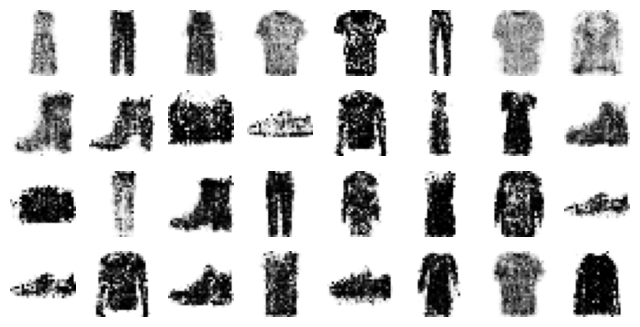

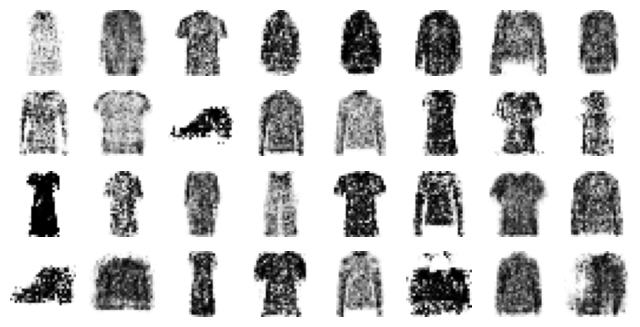

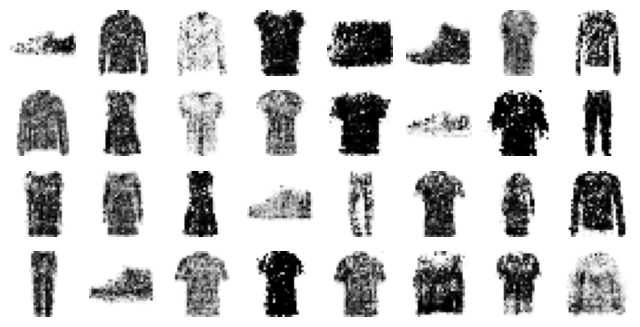

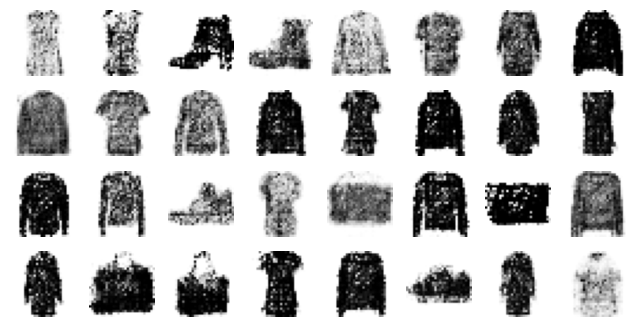

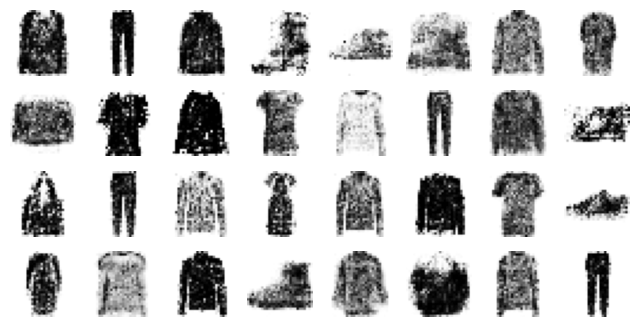

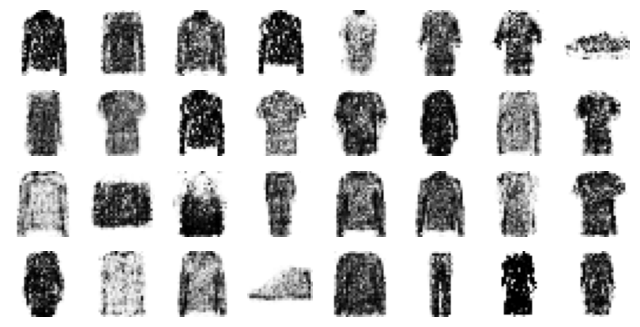

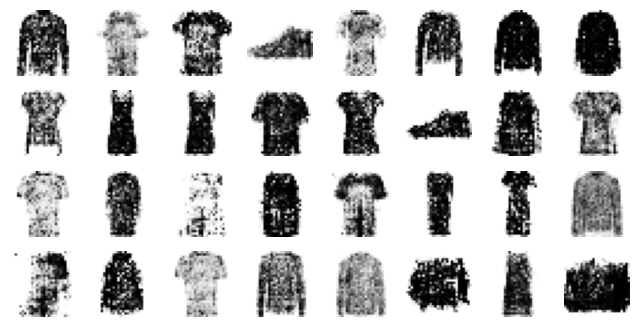

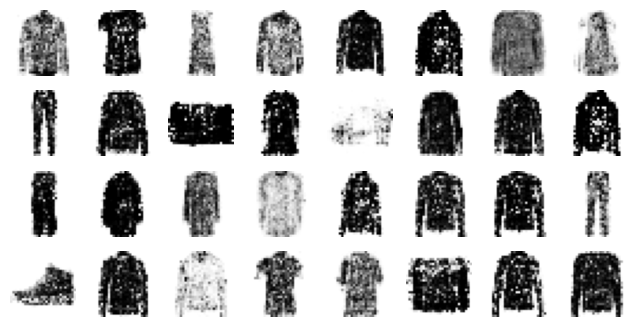

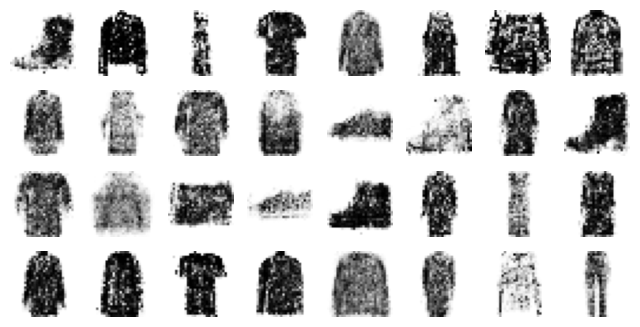

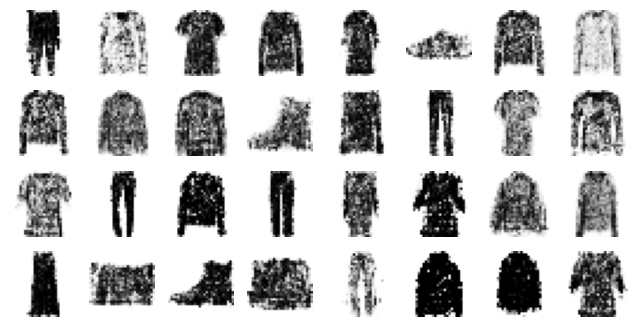

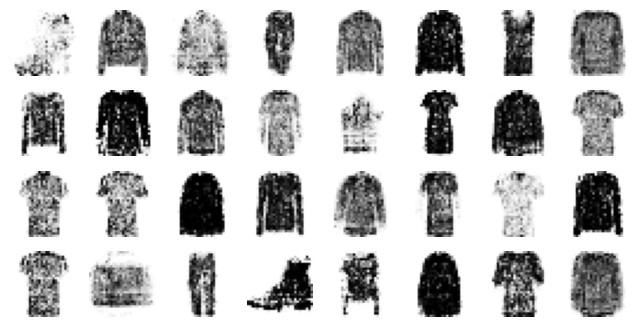

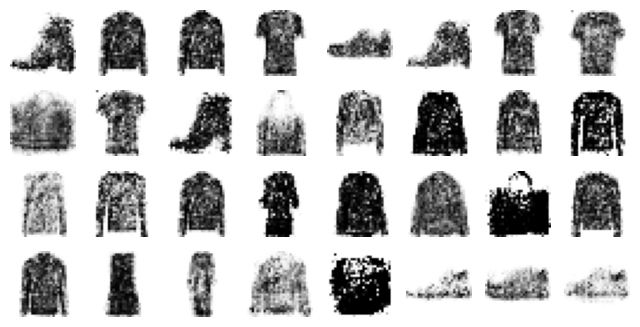

In [15]:
# Since the training loop is unusual, we cannot call the regular fit() method.
# Instead we need to write a custom training loop.

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    for X_batch in dataset:
      # Phase 1 - training the discriminator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_images = generator(noise)

      # Generating 32 fake (label 0) and sampling 32 real (label 1) images
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

      discriminator.train_on_batch(X_fake_and_real, y1)

      # Phase 2 - training the generator

      # In this phase we pass only fake images to the discriminator, but we keep its
      # weights frozen (see above), only training the generator.
      noise = tf.random.normal(shape=[batch_size, codings_size])
      
      # We set the label of these fake images to 1 (real). When the discriminator (
      # not trainable at this phase) labels an image as fake, the generator can improve the
      # weights accordingly - what needs to change so that the discriminator will say it's a
      # real image.
      y2 = tf.constant([[1.]] * batch_size)
      gan.train_on_batch(noise, y2)
      
    print (f"Epoch: {epoch} completed")
    plot_multiple_images(generated_images.numpy(), 8)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=12)


## Deep Convolutional GANs

In [18]:
codings_size = 100

generator = tf.keras.models.Sequential([
  tf.keras.layers.Dense(7 * 7 * 128),
  tf.keras.layers.Reshape([7, 7, 128]),
  tf.keras.layers.BatchNormalization(),
  # upsamples to 14 x 14 with depth reduced to 64
  tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"),
  tf.keras.layers.BatchNormalization(),
  # upsamples to 28 x 28 with depth reduced to 1
  tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")
])

discriminator = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", 
                         activation=tf.keras.layers.LeakyReLU(0.2)),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                          activation=tf.keras.layers.LeakyReLU(0.2)),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")                    
])

gan = tf.keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Epoch: 0 completed
Epoch: 1 completed
Epoch: 2 completed
Epoch: 3 completed
Epoch: 4 completed
Epoch: 5 completed
Epoch: 6 completed
Epoch: 7 completed
Epoch: 8 completed
Epoch: 9 completed


KeyboardInterrupt: 

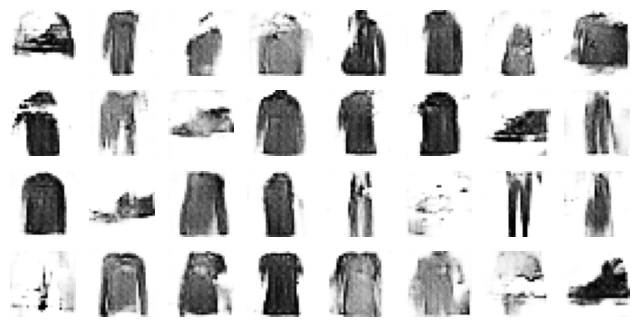

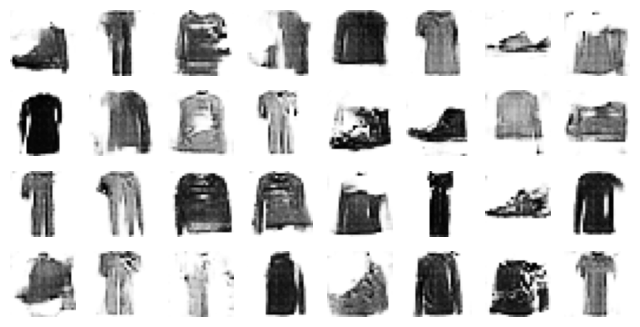

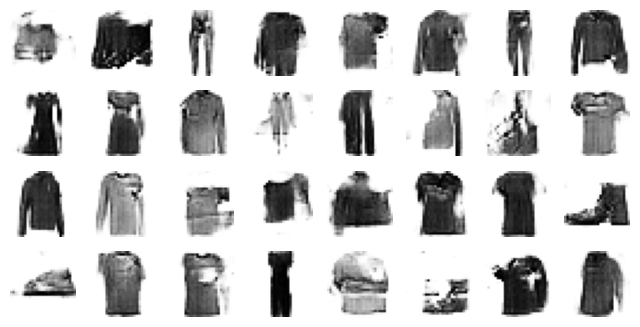

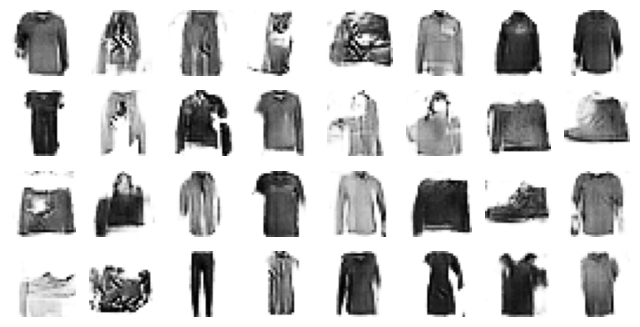

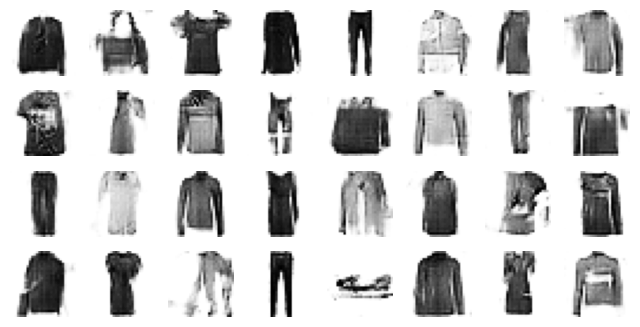

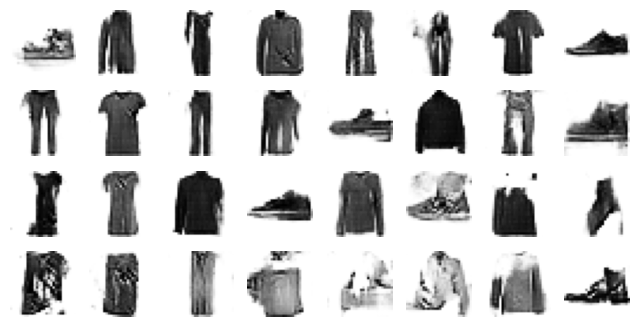

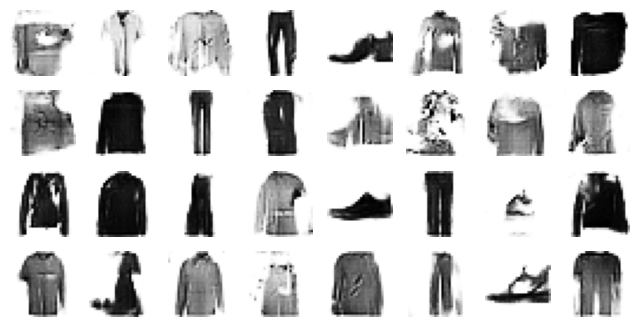

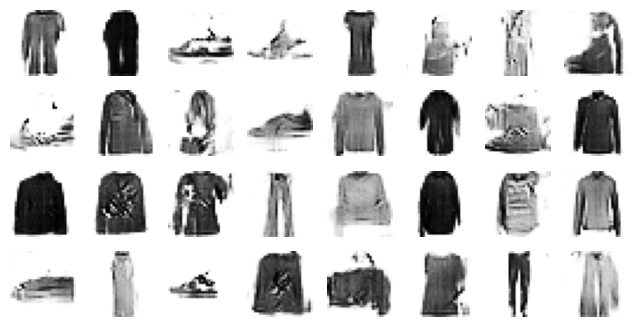

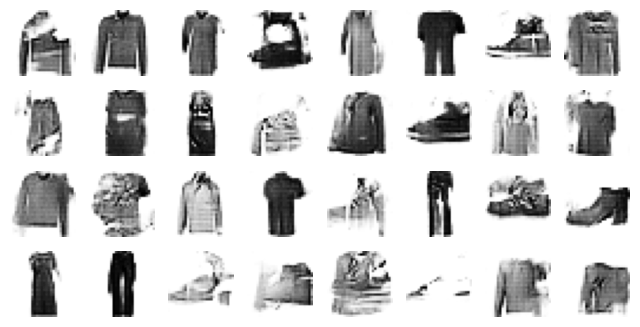

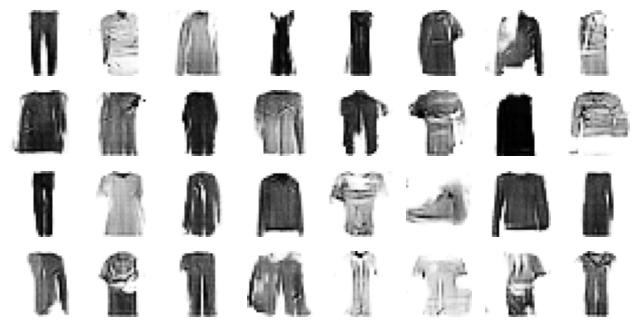

In [19]:
# Reshape and rescale for the dcgan. 
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. 

# Create the dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Train
train_gan(gan, dataset, batch_size, codings_size, n_epochs=12)
